Рогович Татьяна

# Анализ данных  в Python (политология)

## Обнаружение топиков (LDA)


##### 11.12.2019



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer


# Latent Dirichlet Allocation (LDA)

### Построение модели LDA

Для построения модели LDA нам потребуется подготовленный набор данных, состоящий из уже очищенных текстов от стоп-слов.

LDA  - это метод по генерации скрытых топиков в выборке текстов. Например, мы (как в нашем случае) не знаем новости каких категорий попали к нам в набор данных. Мы говорим алгоритму, что мы предполгаем, что в это наборе есть 10 топиков, после чего алгоритм пытается на основе определенных слов выделить 10 кластеров, на которые он мог бы разделить все наши новости. Выделив эти 10 кластеров и характерные для них слова, алгоритм присваивает каждому тексту в датасете топик, который мы уже самостоятельно должны интерпретировать на основе слов-признаков, которыми он определяется.

Как работает LDA на пальцах можно почитать здесь:
https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d

Для нашего примера мы возьмем реальные новости из нашего датасета с фейковыми и реальным новостями. Будет считать, что эти новости были взяты из 10 различных категорий (топиков), позже применив grid search, мы определим оптимальное количество категорий.

Для начала оставим в наших данных, с которыми работали для классификации, только реальные новости.

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/rogovich/2019-2020_PolSci_Data_Analysis_in_Python/master/13week_ML_Text/fake_or_real_news.csv", 
                   header=0)

In [3]:
real_news = data.drop(data[data.label == "FAKE"].index)

In [4]:
real_news.head()

,Unnamed: 0,title,text,label
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
7,95,‘Britain’s Schindler’ Dies at 106,A Czech stockbroker who saved more than 650 Je...,REAL
8,4869,Fact check: Trump and Clinton at the 'commande...,Hillary Clinton and Donald Trump made some ina...,REAL
9,2909,Iran reportedly makes new push for uranium con...,Iranian negotiators reportedly have made a las...,REAL


In [5]:
lemm = WordNetLemmatizer()

def news_to_words(raw_news):

    # 1. Переводим в нижний регистр и разбиваем на токены
    lower_case = raw_news.lower()
    
    # 2. Оставляем только буквы + findall венрнет нам список      
    letters_only = re.findall(r'[a-z]+', lower_case)

    # 3. В Питоне поиск в множествах (set) быстрее чем поиск в
    #   списках, конвертируем список стоп-слов в множество
    stops = set(stopwords.words("english"))                  
    # 
    # 4. Убираем стоп-слова
    meaningful_words = [w for w in letters_only if not w in stops]   
    #
    # 6. Объединяем все слова вместе в одну строчку, разделяя слова пробелом, 
    # и возвращаем результат
    lemmatized = [lemm.lemmatize(word) for word in meaningful_words]
    
    return( " ".join(lemmatized))   

In [6]:
real_news['clean'] = real_news['text'].apply(news_to_words)

In [107]:
real_news.shape

(3171, 5)

In [7]:
X = real_news[["clean"]]
y = real_news["label"]

In [8]:
X.head()

,clean
2,u secretary state john f kerry said monday sto...
4,primary day new york front runner hillary clin...
7,czech stockbroker saved jewish child nazi germ...
8,hillary clinton donald trump made inaccurate c...
9,iranian negotiator reportedly made last ditch ...


Создадим обучающую и тестовую выборки

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=53)

In [10]:
X_train.shape

(2124, 1)

In [11]:
X_test.shape

(1047, 1)

Тренируем наш векторайзер

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(max_features=5000, max_df = 0.7)
count_train = count_vectorizer.fit_transform(X_train['clean'])
count_test = count_vectorizer.transform(X_test['clean'])

In [13]:
count_train

<2124x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 536975 stored elements in Compressed Sparse Row format>

In [14]:
count_test

<1047x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 254366 stored elements in Compressed Sparse Row format>

Импортируем из sklearn функцию LDA и инициализируем ее начальными параметрами

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

In [15]:
from sklearn.decomposition import LatentDirichletAllocation

In [16]:
# Построим модель LDA
lda_model = LatentDirichletAllocation(n_components=10,           # Количество топиков
                                      max_iter=10,               # Макc. количество итераций обучения
                                      learning_method='online',  # Каждый раз, для обновления параметров
                                                                  # выбирается сабсет данных
                                      random_state=100,          # Random state
                                      batch_size=128,            # n документов в каждой итерации online learning
                                      evaluate_every = -1,       # Не высчитываем сложность для каждой итерации (экономим время работы)
                                      n_jobs = -1,               # Использовать все доступные CPUs
                                     )

Тренируем LDA на текстах наших новостей. Чем больше категорий задано в LDA, тем дольше он будет работать

In [17]:
lda_output = lda_model.fit_transform(count_train)

Выведем с какими итоговыми атрибутами построилась модель

In [18]:
print(lda_model)  # Атрибуты модели

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


### Используем GridSearch для получения лучшей модели LDA

При построении модели LDA самыми важным параметром является n_components (количество топиков). В нашем случае мы не знаем откуда были взяты наши новости и из каких категорий. Дополнительно будем еще менять параметр learning_decay (который отвечает за степень обучения).

Стоит напомнить, что грид серч строит несколько моделей LDA для всех возможных комбинаций параметров, указаных при составлении поиска в словаре param_grid. Следовательно, этот процесс может занять изрядное количетво времени и ресурсов.

Импортиурем функцию GridSearch, которая автоматизирует поиск параметров по сетке, который мы раньше реализовывали вручную.

In [19]:
from sklearn.model_selection import GridSearchCV

In [20]:
# Укажем параметры для обучения.
# Имейте ввиду, эта ячейка может исполняться до 15 минут
search_params = {'n_components': [5, 10, 15], 'learning_decay': [.5, .7, .9], 'learning_method': ["online"]} 

# Инициализируем модель
lda = LatentDirichletAllocation()

# Инициализируе класс Grid Search
model = GridSearchCV(lda, param_grid=search_params)

# Выполним Grid Search
model.fit(count_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [5, 10, 15], 'learning_decay': [0.5, 0.7, 0.9], 'learning_method': ['online']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### Определим основные топики и параметры модели

Grid Search закончил свою работу и самое время посмотреть на самую удачную модель и при каких параметрах она получилась.

Сначала получил саму модель для дальнейшего разбора


In [21]:
# После поиска по сетке лучшая модель теперь хранится в параметре 
# best_estimator_ модели.

best_lda_model = model.best_estimator_

Выведем самые подходящие параметры модели

In [22]:
# Параметры модели
print("Best Model's Params: ", model.best_params_)

# Выведем оценку функции правдопободия Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Сложность
print("Model Perplexity: ", best_lda_model.perplexity(count_train))

Best Model's Params:  {'learning_decay': 0.7, 'learning_method': 'online', 'n_components': 5}
Best Log Likelihood Score:  -2308152.865119392
Model Perplexity:  1764.6617749905508


Получили, что наши новости можно разделить на 5 топиков, и некоторые коэффиценты.

Но нужно понимать, что в задаче генерации топиков мы должны оценивать модель и по осмысленности и интерпретируемости топиков.

Perplexity это обратная величина вероятности тестовой выборки, нормализованная количеством слов в выборке. Минимизируя perplexity мы увеличиваем вероятность. Поэтому чем ниже perplexity, тем лучше наша модель натренирована.

Оптимальные значения параметров α и β в модели LDA выбираются так, что бы максимизировать функцию правдоподобия для всех документов в обучающей выборке. Чем выше это значение, тем луше модель считает. Параметры α и β подбираются автоматически внутри модели, на основе параметров которые мы указываем при инициализации LDA, например тотже learning decay

### Сравним разные модели LDA визуально

Посмотрим визуально на наши построеныне модели с различными параметрами

Вытащим данные для разных коэффициентов функции правдоподобия

In [23]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [5, 10, 15]
log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]

C:\Users\rogov\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\rogov\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\rogov\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Нарисуем график и сравним визуально

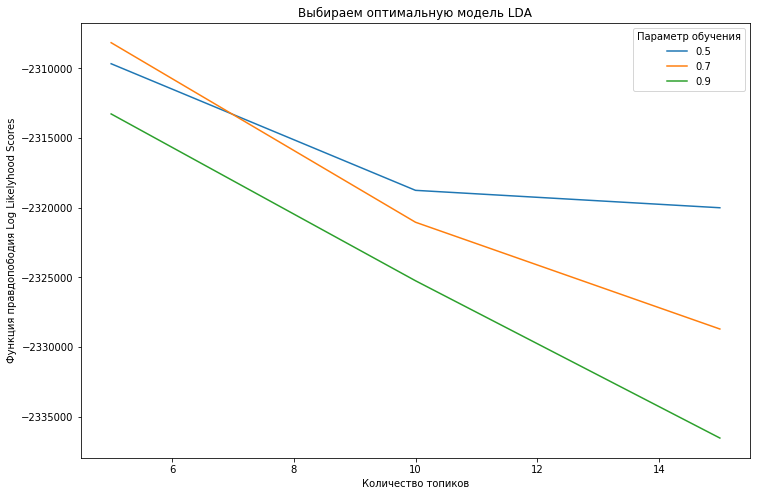

In [24]:
# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Выбираем оптимальную модель LDA")
plt.xlabel("Количество топиков")
plt.ylabel("Функция правдопободия Log Likelyhood Scores")
plt.legend(title='Параметр обучения', loc='best')
plt.show()

Давайте проанализируем графики. По вертикальной оси у нас значения функции правдоподобия. По горизионтальной количество топиков. Максимальное значение мы имеем при количестве топиков 5 и при параметре обучения 0.7. Как раз это нам и сказал Grid Search.

Если не знать точного количество топиков (как в нашем случае), то GridSearch может стать хорошим помощником в этом деле и его результатам стоит доверять.

Теперь выведем топики, которые наша самая лучшая модель нашла.

Напишем сначала функцию, которая нам будет красиво выводить название топика и примерный текст, по которому мы сможем определить категорию.

Стоить отметить что она НЕ скажет вам название категории. Только человек, посмотрев на получившийся текст можно для классифицировать название топика.

In [25]:
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

Выведем наши топики

In [26]:
# Количество слов, которое мы хотим вывести для каждого топика
n_top_words = 40

print("\nTopics в модели LDA: ")

# Получаем топики
tf_feature_names = count_vectorizer.get_feature_names()
print_top_words(best_lda_model, tf_feature_names, n_top_words)


Topics в модели LDA: 

Topic #0:trump people american like say time president would clinton woman year white know right even many think thing make way america country new donald get bush going first political medium life much want black also obama news campaign back hillary

Topic #1:attack isi state islamic iraq military syria group force war official terrorist people security al also country government killed president russia paris syrian united two russian told world obama would militant news year minister say terrorism city fighter report foreign

Topic #2:state police law department court gun people year email justice officer time would official shooting two clinton right told case marriage city also day report federal new say could according investigation fbi black community news government information statement religious church

Topic #3:obama would year state president republican house congress american deal government policy senate tax iran say percent new could bill also adm

Получилось достаточно хорошо. Например, топик 0 у нас получился с новостям про полицию и стрельбу. Топик 1 - террористы и войны. Топик 2 - внутренняя политика. Топик 3 - выборы. 4 - тоже выборы.
Возможно, 4 топика показали бы еще лучший результат, так как мы видим, что 3 и 4 достаточно близки.

Тут уже нужен человек, чтобы оценить качество полученного результата.


### Получаем топ 15 слов на каждый топик

Давайте посмотрим на 15 самых встречающихся слов в каждом топике. Это полезно для понимания почему какой-либо текст мог попасть в один из топиков и для наглядного сравнения их друг с другом.

Создадим следующую функцию, в которую мы передаем нашу модель, векторайзер с помощью которого мы делали токенезацию текста и количество слов, которое мы хотим получить.

In [27]:
def show_topics(vectorizer=count_vectorizer, lda_model=lda_model, n_words=20):
    # получили топ слов из векторайзера
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

Создадим ДатаФрейм с колонками из слов и строками из топиков

In [28]:
topic_keywords = show_topics(vectorizer=count_vectorizer, lda_model=best_lda_model, n_words=15)        

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,trump,people,american,like,say,time,president,would,clinton,woman,year,white,know,right,even
Topic 1,attack,isi,state,islamic,iraq,military,syria,group,force,war,official,terrorist,people,security,al
Topic 2,state,police,law,department,court,gun,people,year,email,justice,officer,time,would,official,shooting
Topic 3,obama,would,year,state,president,republican,house,congress,american,deal,government,policy,senate,tax,iran
Topic 4,trump,clinton,republican,campaign,party,state,candidate,sander,voter,cruz,new,democratic,presidential,poll,rubio


###  Как мы можем предсказывать топик новым текстам

Наша модель уже натренирована и мы можем давать ей новые тексты, которым она присвоит один из ранее определенных топиков. В идеальном случае она это сделает верно, при условии что и разметка топиков прошла успешно. У нас есть тестовые данные, на которых можно проверить нашу модель.

Дадим натреннированной модели наши тестовые данные

In [29]:
topic_probability_scores = best_lda_model.transform(count_test)

Выведем получившиеся оценки

In [30]:
print(topic_probability_scores)

[[1.45837507e-01 1.26000652e-04 1.26109616e-04 2.17471792e-02
  8.32163203e-01]
 [3.04327725e-01 6.56074375e-04 6.58868015e-04 6.60469359e-04
  6.93696864e-01]
 [6.53044512e-01 5.75741708e-04 5.11748481e-02 2.26201708e-02
  2.72584727e-01]
 ...
 [4.03464619e-04 4.04907034e-04 1.42467790e-02 7.90259162e-01
  1.94685688e-01]
 [5.44385823e-02 3.28443122e-01 5.76586783e-01 1.64522122e-04
  4.03669912e-02]
 [9.76399861e-04 1.53603903e-01 7.90414792e-02 7.65400812e-01
  9.77405717e-04]]


Как мы видим для каждой новости из тестовой выборки, модель возвращает 5 чисел, которые соответствуют насколько данная новость попадает в один из топиков. Выбираем максимум в каждом ряду и получаем топик, к которому данная новость ближе всего.

Давайте напишем функцию, которая будет выводить присвоенный топик и текст новости

In [31]:
def get_topic_text(topic,i):
    print(f"Новость {i} попадает в {topic} топик\n")
    print(X_test.values[i])
    print("-"*30)

Теперь пройдемся по каждой строчке и выберем на ней максимальный элемент. Для выделения индекса максимального элемента в строке воспользуемся функцией argmax из модуля numpy. В нашем случае индексы и будет соответствовать номеру топика. Выведем первые 5 новостей для тестирования.

In [32]:
for i in range(5):
    get_topic_text((np.argmax(topic_probability_scores[i])),i)

Новость 0 попадает в 4 топик

['donald trump dominated gop presidential race seven month nothing many offensive comment mediocre debate performance feared gop establishment able stop rise february could change trump face far biggest challenge yet iowa caucus result iowa first time state actual voter weigh presidential nomination contest make national contest turn dime barack obama iowa suddenly shot become competitive hillary clinton national poll john kerry came nowhere win iowa presumed leader howard dean collapsed astonishing speed trump could vulnerable iowa taken lead recent poll anecdotal report suggesting trump ground game crucial low turnout caucus laughably inferior ted cruz first contest really count trump could end loser yet manages pull win watch let step back minute ask quirky iowa caucus tremendous impact race anyway difference first place third place iowa going vote like student body election state small population overwhelmingly white turnout caucus absurdly low democra

Проанализируйте тексты и подумайте, насколько точно они соотвествуют присвоенным топикам

### Wordcount

Визуализируем наши топики Облаком слов (Wordcount). Для этого нужно сначала установить саму библиотеку "!pip install wordcount"

In [33]:
!pip install wordcloud

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Для каждого топика извлечем его компоненты. Атрибут components возвращает количество раз слово j было "назначено" топику i. По факту это таблица components_[i, j]. Мы возвращаем для каждого топика сколько раз каждое слова были отнесено к нему.

In [34]:
first_topic = best_lda_model.components_[0]
second_topic = best_lda_model.components_[1]
third_topic = best_lda_model.components_[2]
fourth_topic = best_lda_model.components_[3]
fifth_topic = best_lda_model.components_[4]

Посмотрим на количество слов в каждой компоненте

In [35]:
first_topic.shape

(5000,)

Соответсвенно имеем 5000 слов, у каждого из которых есть количество попадания в конкретный топик.

Отсортируем в порядке убывания наши слова. Сначала получим признаки.


In [36]:
tf_feature_names = count_vectorizer.get_feature_names()

Сортируем 50 слов для каждого топика

In [37]:
first_topic_words = [tf_feature_names[i] for i in first_topic.argsort()[:-50 - 1 :-1]]
second_topic_words = [tf_feature_names[i] for i in second_topic.argsort()[:-50 - 1 :-1]]
third_topic_words = [tf_feature_names[i] for i in third_topic.argsort()[:-50 - 1 :-1]]
fourth_topic_words = [tf_feature_names[i] for i in fourth_topic.argsort()[:-50 - 1 :-1]]
fifth_topic_words = [tf_feature_names[i] for i in fifth_topic.argsort()[:-50 - 1 :-1]]

Импортируем сам модуль WordCount. WordCount только генерирует текст, который еще нужно нарисовать с помощью matplotlib.

In [41]:
from wordcloud import WordCloud

Инициализируем объект WordCloud нашими словами из первого топика

In [42]:
firstcloud = WordCloud(
                          background_color='white', # Цвет фона
                          width=2500,
                          height=1800
                         ).generate(" ".join(first_topic_words)) # передаем слова

Рисуем на графике получившийся облако

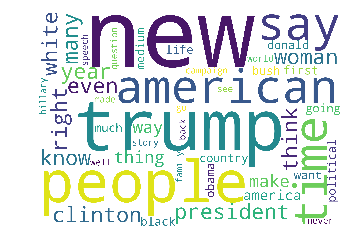

In [43]:
plt.imshow(firstcloud)
plt.axis('off')
plt.show()

Построим аналгичное для всех остальных топиков

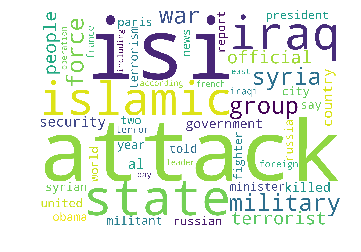

In [44]:
secondcloud = WordCloud(
                          background_color='white', # Цвет фона
                          width=2500,
                          height=1800
                         ).generate(" ".join(second_topic_words)) # передаем слова

plt.imshow(secondcloud)
plt.axis('off')
plt.show()

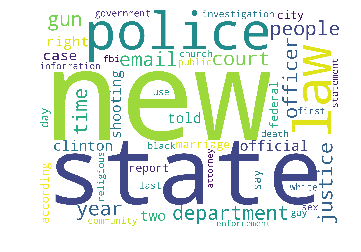

In [45]:
thirdcloud = WordCloud(
                          background_color='white', # Цвет фона
                          width=2500,
                          height=1800
                         ).generate(" ".join(third_topic_words)) # передаем слова

plt.imshow(thirdcloud)
plt.axis('off')
plt.show()

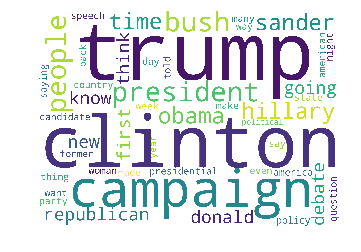

In [149]:
fourthcloud = WordCloud(
                          background_color='white', # Цвет фона
                          width=2500,
                          height=1800
                         ).generate(" ".join(fourth_topic_words)) # передаем слова

plt.imshow(fourthcloud)
plt.axis('off')
plt.show()

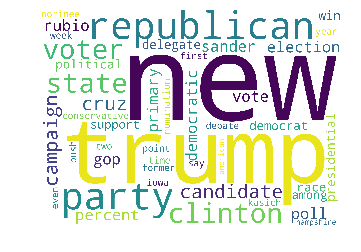

In [150]:
fifthcloud = WordCloud(
                          background_color='white', # Цвет фона
                          width=2500,
                          height=1800
                         ).generate(" ".join(fifth_topic_words)) # передаем слова

plt.imshow(fifthcloud)
plt.axis('off')
plt.show()